# Computing SST-wind coupling intensity for different environmental conditions

## To do's

## Details

@author: Lorenzo Francesco Davoli

@creation: 16/05/2025

@project: hk25-ASIntTrops

@github: 

@contact: l.davoli@campus.unimib.it

@notes: 

# Packages, constants functions and controls

## Packages

In [1]:
import sys
import os
from glob import glob
from tqdm import tqdm
# My utility funtions from "miscellanea" directory
# append a new directory to sys.path
#sys.path.append('/home/lorenzo/Phase-SST-wind-coupling/miscellanea')
#from my_utility_functions import sym_log, plot_lat_lon_on_global_map
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t
import geometry as gm # grad_sphere, div_sphere, nan_gaussian_filter, L2wind_2_regular_grid_mask
#import distributions as dstr # mixed_distribution, mixed_distribution_with_hist (also with two samples)
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.special import gammaincc

import cartopy.feature as cfeature
from shapely.geometry import Point, Polygon
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.filterwarnings("ignore")


## Constants

In [2]:
# Specific heat dry air at const p
c_p = 1005 #[J kg-1 K-1]
# Specific gas constant for dry air
R_d = 287.05 #[J/(kg K)]
# Specific gas constant for water vapor
R_v = 461.52 #[J/(kg K)]
# Water vaporization specific latent heat (Stull)
L_v = 2500000 #2268000 #[J/kg] 
# L_v/R_v, Specific heat moist air at const p (source: Stull, pag. 89, https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet/PracticalMet_WholeBook-v1_00b.pdf)
c_water = 5423 #[K] 
# Gravit accel
g = 9.81 #[m s-2]
# Von Karman constant
kappa = 0.4 #[1]
# epsilon = R_d/R_v
eps = 0.622 #[g/g]
# beta ~ (R_v/R_d)-1
beta = 0.608 
# saturation vapor pressure 
e0 = 611.3 #[Pa]
# Water freezing temperature
T0 = 273.15 # [K]
# Constants of Tetens' formula for saturated air water content (eq 4.2, Stull, pag. 89, https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet/PracticalMet_WholeBook-v1_00b.pdf)
b = 17.2694
T1 = T0 #[K]
T2 = 35.86 #[K]

## Functions

In [3]:
def extract_elements_from_bool_list(var_ar,bool_ar):
    '''
        Extract elements from var_ar array according to bool criterion in bool_ar
    '''
    return [ value for i,value in enumerate(var_ar) if bool_ar[i] ]

# def compute_specific_humidity(RH,T,p):
#     '''
#         Compute the specific humidity q starting from the relative humidity RH, 
#         the air temperature T, the air pressure p)
#     '''
#     # Use Tetens formula for computation of saturation vapor pressure e_s
#     e_s = 6.122*np.exp((17.67*T)/(T+243.5))
#     # Compute vapor pressure e
#     e = RH*e_s/100
#     # Compute the specific humidity
#     q = 0.633*e/(p-0.378*e)

#     return q

        
def compute_specific_humidity(d,sp): # 
    """
    Calculates specific humidity q from the dew-point temperature d, the temperature T and the surface pressure sp. 
    Source: equation 4.24, Pg 96 Practical Meteorolgy (Roland Stull)
    from https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet/PracticalMet_WholeBook-v1_00b.pdf
    """
    q = (eps * e0 * np.exp(c_water * (1/T0 - 1/d)))/sp # [g/kg] 
    return q #[g/g]

def compute_relative_humidity(T,d):
    """
    Calculates relative humidity RH (%) from  the air temperature T and the dew-point temperature d. 
    Source: equation 4.2+4.14a, Pg 89 Practical Meteorolgy (Roland Stull)
    from https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet/PracticalMet_WholeBook-v1_00b.pdf
    """
    e = e0 * np.exp(c_water * (1/T0 - 1/d)) # (4.1b)
    e_s = e0*np.exp(b*(T-T1)/(T-T2))
    RH = e/e_s*100 # [%]
    return RH

def compute_virtual_temperature(T,q):
    '''
        Compute virtual temperature T_v from surface air temperature T, specific humidity q
    '''
    T_v = T * (1+beta*q)

    return T_v

def compute_air_density(sp,T_v):
    '''
        Compute air density rho given surface pressure sp and virtual temperature T_v (ideal gas law)
    '''
    rho = sp / (R_d * T_v)

    return rho

def compute_buoyancy_flux(rho,T_v,T,H_s,H_l,q):
    '''
        Compute the buoyancy flux B at the surface starting from air-density rho, 
        virtual air temperature T_v, sensible and latent heat fluxes, 
        specific humidity q. 
        Positive B => positive heat flux into the ocean => stable conditions.
        The reference (De Szoeke) computes B as a kinematic flux, so I have to 
        multiply by rho*c_p to obtain a dynamic flux (as the one in B_ML_50)
        Source: De Szoeke et al. (2020) for the comput of the kinetic flux wT, 
        and then multiplied by rho*c_p according to glossary of meteorology to 
        obtain a density flux (virt temperature per unit of area per second),
        as the one compute by COARE.
    '''
    
    B = c_p * ( H_s*(1+beta*q)/c_p + H_l*beta*T/L_v )

    return B


def compute_buoyancy_flux_Q_contribution(rho,T_v,H_s,H_l,q):
    '''
        Returns the sensible heat term contributing to buoyancy flux B at the surface starting from air-density rho, 
        virtual air temperature T_v, sensible heat flux, 
        specific humidity q
    '''
    
    Q = g/(rho*T_v) * H_s*(1+beta*q)/c_p 

    return Q


def compute_buoyancy_flux_L_contribution(rho,T_v,T,H_s,H_l,q):
    '''
        Returns the latent heat term contributing to buoyancy flux B at the surface starting from air-density rho, 
        virtual air temperature T_v, sensible heat flux, 
        specific humidity q
    '''
    
    L = g/(rho*T_v) * H_l*beta*T/L_v 

    return L


def compute_Obukhov_length(T_v,u_star,B,rho):
    '''
        Returns Obukhov length from friction velocity u_star and B (i.e. virtual temperature dynamic flux B) 
        as L = - T_v * u_star^3 / (kappa * B / (rho*c_p) ).
        Sources: Stull (1988) for L formula + De Szoeke (2020) for wT_v formula + gloss of meteo for dyn flux.
        Note: B is positive (negative) for unstable (stable) conditions. Depending on how B is defined
        the minus signs is removed.
    '''
    L = T_v * np.power(u_star,3) * rho * c_p / (kappa * g * B)

    return L

def compute_potential_temperature(T,P,P0 = 100000):
    '''
        Return the potential temperature theta with respect to the reference pressure P0 (default 10000 Pa).
        P [Pa] 
        T [K]
        Sources: Stull (1988), eq 3.12 p. 61. 
    '''
    theta = T * np.power(P0/P,R_d/c_p)

    return theta

import numpy as np


def compute_wind_direction(u, v):
    """
    Calculate the wind direction from u and v wind components.
    Source: https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
    Parameters:
    u (float or np.array): Wind component in the east-west direction.
    v (float or np.array): Wind component in the north-south direction.
    
    Returns:
    float or np.array: Wind direction in degrees, [0:360], wrt N, positive clockwise.
    """
    
    wind_dir_deg = np.mod(180/np.pi*np.arctan2(u, v) + 180,360)
    
    return wind_dir_deg


def is_within_polygon(lon, lat, polygon):
    '''
    Define a function to check if a point is within the polygon.
    '''
    point = Point(lon, lat)
    return polygon.contains(point)


def weighted_linear_regression_with_pvalues(x, y, sigma_y):
    '''         
        Compute a weighted linear regressio of (x,y+/-sigma_y),
        where the uncertainty on y observations is taken into 
        account.
        Returns a dictionary in the form:
                "intercept" : (intercept, sigma_b),
                "slope" : (slope, sigma_m),
                "chi2" : chi square value,
                "q" : goodness of fit

        From Numerical Recipe 15.2
        If q is larger than, say, 0.1,then the goodness-of-fit is believable. 
        If it is larger than, say, 0.001, then the fit may be acceptable if the 
        errors are nonnormal or have been moderately underestimated. If q is 
        less than 0.001, then the model and/or estimation procedure can rightly
        be called into question. In this latter case, turn to 15.7 to proceed 
        further.
    '''

    '''
    ### ChatGPT
    # Compute weights
    weights = 1 / np.power(sigma_y,2)
    W = np.diag(weights)
    
    # Construct fit matrix, take the transform (.T)
    X = np.vstack((np.ones_like(x), x)).T  # [[1, x1], [1, x2], ...]
    
    # Solve for parameters (b, m), with y = b + m*x
    XT_W = X.T @ W 
    # Parameters for the solution
    beta = np.linalg.inv(XT_W @ X) @ (XT_W @ y)  # [b, m]
    
    # Compute covariance matrix
    cov_beta = np.linalg.inv(XT_W @ X)
    sigma_b, sigma_m = np.sqrt(np.diag(cov_beta))  # Uncertainties
    
    # [BROKEN] Compute p-values
    intercept, slope = beta
    t_intercept = intercept / sigma_b
    t_slope = slope / sigma_m
    
    # Degrees of freedom
    dof = len(x) - len(beta)  # N - p
    

    # Compute two-tailed p-values using the t-distribution
    p_intercept = 2 * t.sf(abs(t_intercept), dof)
    p_slope = 2 * t.sf(abs(t_slope), dof)

    # # Compute two-tailed p-values using survival function from scipy
    # p_intercept = 2 * stats.rv_continuous.sf(abs(t_intercept), df)
    # p_slope = 2 * stats.rv_continuous.sf(abs(t_slope), df)
    #p_intercept = None
    #p_slope = None

    # Results
    return {
        "intercept": (intercept, sigma_b, p_intercept),
        "slope": (slope, sigma_m, p_slope),
        "covariance_matrix": cov_beta,
    }

    '''

    '''
    ### Numerical recipe 15.2 (https://numerical.recipes/book.html), handmade
    # y = a + bx
    S = np.sum(np.power(sigma_y,-2))
    S_X = np.sum(np.power(sigma_y,-2)*x)
    S_y = np.sum(np.power(sigma_y,-2)*y)
    S_XX = np.sum(np.power(sigma_y,-2)*np.power(x,2))
    S_Xy = np.sum(np.power(sigma_y,-2)*np.multiply(x,y))
    
    Delta = S*S_XX - S_X**2
    a = (S_XX*S_y - S_X*S_Xy)/Delta
    b = (S*S_Xy - S_X*S_y)/Delta
    var_a = S_XX/Delta
    var_b = S/Delta
    sigma_a = np.sqrt(var_a)
    sigma_b = np.sqrt(var_b)
    '''

    # Numerical recipe code 15.2 (https://numerical.recipes/book.html)
    # Translated to python by copilot and checked.
    ndata = len(x)
    x = np.array(x)
    y = np.array(y)
    sigma_y = np.array(sigma_y)
    
    ss = 0.0
    sx = 0.0
    sy = 0.0
    st2 = 0.0
    b = 0.0
    chi2 = 0.0
    q = 1.0 # Estimator for goodness of fit.
    '''
        From Numerical Recipe 15.2
        If Q is larger than, say, 0.1,then the goodness-of-fit is believable. 
        If it is larger than, say, 0.001, then the fit may be acceptable if the 
        errors are nonnormal or have been moderately underestimated. If Q is 
        less than 0.001, then the model and/or estimation procedure can rightly
        be called into question. In this latter case, turn to 15.7 to proceed 
        further.
    '''

    for i in range(ndata):
        wt = 1.0 / (sigma_y[i] ** 2)
        ss += wt
        sx += x[i] * wt
        sy += y[i] * wt

    sxoss = sx / ss

    for i in range(ndata):
        t = (x[i] - sxoss) / sigma_y[i]
        st2 += t * t
        b += t * y[i] / sigma_y[i]

    b /= st2
    a = (sy - sx * b) / ss
    sigma_a = np.sqrt((1.0 + sx * sx / (ss * st2)) / ss)
    sigma_b = np.sqrt(1.0 / st2)

    for i in range(ndata):
        chi2 += ((y[i] - a - b * x[i]) / sigma_y[i]) ** 2

    if ndata > 2:
        q = gammaincc(0.5 * (ndata - 2), 0.5 * chi2)

    return {
        "intercept": (a, sigma_a),
        "slope": (b, sigma_b),
        "chi2" : chi2,
        "q" : q,
    }

In [4]:
# Tool to fix file names
if False:
    files = glob(path2sst_wind_derivatives_output+'/DMM_zoom_11_latlon_res_2.0km_high_pass_5_eurec4a_extended*')
    for file in files:
        os.rename(file,file[:-52]+f'timeres_{time_res}_'+file[-52:])

## Controls

In [5]:
#############################
### SPACE AND TIME DOMAIN ###
#############################

# Set the geographical parameters for the analysis and the figures.
# Look at the areas of the WBCs defined by O'Neill et al, J. Cli (2012).
area_str = 'gulf_stream'; area_name = 'Gulf Stream' ; minlon = -83.; maxlon = -30.; minlat = 30.; maxlat = 55.
#area_str = 'malvinas'; area_name = 'Malvinas current' ; minlon = -70.; maxlon = 0.; minlat = -60.; maxlat = -30.;

# Set some parameters for the maps.
region_extent = [minlon, maxlon, minlat, maxlat]
crs = ccrs.PlateCarree()

# Set the period to analyse
# AVHRR MetOp A ICDRv2.1 L3C SSTskin data are available until Sept 2021
# For now i have downloaded only MetOp A ASCAT until March 2020.
if False:
    if area_str == 'malvinas':
        period_start = '2000-01-01' 
        period_end = '2015-12-31' 
    elif area_str == 'gulf_stream':
        period_start = '2000-01-01' 
        period_end = '2021-12-31' 
    else:
        raise NameError('Undefined period')
else:
    # Overwrite if necessary
    period_start = '2000-01-01' 
    period_end = '2000-02-29' 

# Coastal sector used to analyze coastal effects
# Polygon following the GS coast from 30°N 82°W to 40°N 72°W.
coastal_sector_coords = [
    (-82, 30),  # Bottom-left corner
    (-70, 45),  # Top-left corner
    (-63, 45),  # Top-right corner
    (-53, 47),  # Top-right corner
    (-53, 50),  # Top-right corner
    (-48, 50),  # Top-right corner
    (-48, 45),  # Top-right corner
    (-53, 42),  # Top-right corner
    (-66, 40),  # Top-right corner
    (-74, 30),  # Bottom-right corner
    (-82, 30)  # Closing the polygon
]
# Create the Polygon object
coastal_sector_polygon = Polygon(coastal_sector_coords)

# Threshold used to select domains in the analysis
#lat_north_threshold = 37
lat_north_threshold = np.inf
#lon_west_threshold = -63
lon_west_threshold = -np.inf


#######################
### DATA DEFINITION ###
#######################

# Path to the files containing wind and SST derivative fields build through
# the script "generate_fields_with_ERA5_wind_sst_derivatives.ipynb". 
path2sst_wind_derivatives_output = '/home/b/b383497/b383497/fields/'
model='ifs_tco3999-ng5_rcbmf_cf'
time_res = 'PT1H'
fine_zoom = 11
fine_latlon_gridstep = 0.02 # [°]
submeso_pass_lower_sigma = 5

############################
### MECHANISM TO ANALYSE ###
############################

# Select here the fields to be analysed.
str_mech = 'DMM'
#str_mech = 'PA'
if str_mech == 'DMM':
    sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
    wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    blh_deriv = 'dblh_prime_dr'
elif str_mech == 'PA':
    sst_deriv = 'd2sst_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    wind_deriv = 'dblh_prime_ds'
else: 
    raise NameError('Mechanism not recognised')

##############################
### ANALYSES CONFIGURATION ###
##############################

# Remove outliers?
# If you don't remove outliers there are several non-linearity emerging.
enable_outliers_filter = False
# Percentile filter for outliers (applied at both extremes, so 2.5 == 2.5% to 97.5% accepted per variable it is applied to)
outliers_filter_percentile = 2.5

# Remove the central peak (wrt control variable) to compute the regressions 
# on the tails only, without its influence?
enable_remove_central_peak = False
# Percentile of central data to be removed (%)
percentile_removed_from_central_peak = 95

# Filters points with low background wind, as Owen should have ruled them out
enable_low_background_wind_filter = False
low_background_wind_threshold = 4 #(m/s)

# Type of error to be associated to the control bin mean responses
control_bin_error = 'sem' # or 'std'

# Min value of goodness of fit q for a weighted linear regression to be accepted
q_threshold = 0.1

# Number of bins to use in the binning of control and response fields 
# before computing the linear regression.
control_bins = 20

# Define explicitely the control bins?
enable_hardcode_control_bins = False
hardcoded_control_bins_ar = pd.IntervalIndex.from_tuples([
    (-np.inf,0),(0,np.inf),
    ])

# Fix the control bins across the whole analysis, depending on 
# the entire dataset (not on the env classes subsets)
# If True, the same bins are used for every env class, ensuring
# comparability in the estimates of the coefficients.
# If False, adapt the bins to the points of each env class,
# thus improving the sampling of that specific population of data.
enable_shared_control_bins = False
if enable_hardcode_control_bins and enable_shared_control_bins:
    raise NameError('Define only 1 structure for the control bins')

# Minimum number of points inside a control bin to be accepted in the computation
# of the linear regression.
# If we are considering the coloc with SAR we do not have much data, so we lower the
# quality requirement when binning the control variable in the background ws
# analysis. On the other hand, the log_L analysis is always colocated, and therefore
# we keep a low control_bin_n_points_threshold_log_L.
control_bin_n_points_threshold = 50

# Define the minimum number of points for lin regr of unbinned data
unbinned_n_points_threshold = 500

# Define how many control_bins have to be present in order for the lin regression
# to be considered reliable. 
# Consider that "n_control_bins_threshold_log_L" has to be smaller (optimally by 2-3 units) 
# than "control_bins".
# As the data are norm distributed, this is also an indirect control
# on the minimum range of env values to be covered.
n_control_bins_threshold = 5
# If we are fixing the number of bins and it's smaller we adapt
if enable_hardcode_control_bins and len(hardcoded_control_bins_ar) < n_control_bins_threshold:
    n_control_bins_threshold = len(hardcoded_control_bins_ar)

# Plot the number of points on the 2D env cond graph
# instead of the significance. Use in case you have only 2 control
# bins, and check the code bcs is not well implemented.
if (enable_hardcode_control_bins and len(hardcoded_control_bins_ar) == 2) or control_bins == 2:
    plot_n_points_in_2Denvcond_graph = True
else:
    plot_n_points_in_2Denvcond_graph = False


################################
### ENVIRONMENTAL CONDITIONS ###
################################

# Prescribed environmental classes.
# The last one has to comprehend all the possible values.
env_cond_class_dict = {
    'background_ws' : [
        [0,5],
        [5,12],
        [12,np.inf],
        [-np.inf,np.inf]
    ],
    'smooth_ws' : [
        [0,5],
        [5,12],
        [12,np.inf],
        [-np.inf,np.inf]
    ],
    'air_sea_temp_diff_era5' : [
        [-np.inf,-8],
        [-8,-4],
        [-0.25,0.25],
        [1,np.inf],
        [-np.inf,np.inf]
    ],
    'smooth_air_sea_temp_diff' : [
        [-np.inf,-8],
        [-8,-4],
        [-0.25,0.25],
        [1,np.inf],
        [-np.inf,np.inf]
    ],
    'air_sea_theta_diff_era5' : [
        [-np.inf,-8],
        [-8,-4],
        [-4,0],
        [0,np.inf],
        [-np.inf,np.inf],
        ],
    'RH_era5' : [
        [0,60],
        [60,70],
        [70,100],
        [0,100],
    ],
    't2m_era5' : [
        [-np.inf,273.15],
        [273.15,278.15],
        [278.15,283.15],
        [283.15,np.inf],
        [-np.inf,np.inf],
    ],
    'sst_era5' : [
        [-np.inf,278.15],
        [278.15,283.15],
        [283.15,293.15],
        [293.15,np.inf],
        [-np.inf,np.inf],
    ],
    'smooth_sst' : [
        [-np.inf,278.15],
        [278.15,283.15],
        [283.15,293.15],
        [293.15,np.inf],
        [-np.inf,np.inf],
    ],
    'smooth_tas' : [
        [-np.inf,273.15],
        [273.15,278.15],
        [278.15,283.15],
        [283.15,np.inf],
        [-np.inf,np.inf],
    ],
    'tp_era5' : [
        [-np.inf,0.0000001],
        [0.0000001,np.inf],
        [-np.inf,np.inf],
    ],    
    'cp_era5' : [
        [-np.inf,0.0000001],
        [0.0000001,np.inf],
        [-np.inf,np.inf],
    ],    
    'tcc_era5' : [
        [0,0.4],
        [0.4,1],
        [0,1],
    ],
    'wdir_era5' : [
        [0,90],
        [90,180],
        [180,270],
        [270,360],
        [0,360],
    ],
    'u10_era5' : [
        [-np.inf,np.inf],
    ],
    'v10_era5' : [
        [-np.inf,np.inf],
    ],
    'lat' : [
        [30,37],
        [40,60],
    ],
    'coastal' : [
        [-0.1,0.5],
        [0.5,1.1],
        [-0.1,1.1],
    ]
}

env_cond_class_color_dict = {
    'background_ws' : ['blue','purple','red','black'],
    'smooth_ws' : ['blue','purple','red','black'],
    'air_sea_temp_diff_era5' : ['cyan','blue','purple','red','black'],
    'smooth_air_sea_temp_diff' : ['cyan','blue','purple','red','black'],
    'smoothed_air_sea_temp_diff_era5' : ['cyan','blue','purple','red','black'],
    'air_sea_theta_diff_era5' : ['cyan','blue','purple','red','black'],
    'RH_era5' : ['red','purple','blue','black'],
    't2m_era5' : ['cyan','blue','purple','red','black'],
    'sst_era5' : ['cyan','blue','purple','red','black'],
    'tp_era5' : ['blue','red','black'],
    'cp_era5' : ['blue','red','black'],
    'tcc_era5' : ['blue','red','black'],
    'wdir_era5' : ['cyan','blue','purple','red','black'],
    'u10_era5' : ['black'],
    'v10_era5' : ['black'],
    'lat' : ['blue','red'],
    'coastal' : ['cyan','blue','black'],
    }

# Columns to extract from fields file
cols_to_extract = [
    sst_deriv,
    wind_deriv,
    blh_deriv,
    'smooth_ws',
    'smooth_sst',
    'smooth_tas',
]

# List of the comparison between env conditions we want to compute
# format: [x_env_cond,y_env_cond,hue_env_cond]
# hue_env_cond can be None if not needed
env_cond_comparison_ar = [
    [
        'smooth_air_sea_temp_diff',
        'smooth_ws',
        None,
    ],
    [
        'air_sea_temp_diff_era5',
        'B_era5',
        'background_ws',
    ],
    [
        'air_sea_temp_diff_era5',
        'pos_log_L_era5',
        None,
    ],
    [
        'air_sea_temp_diff_era5',
        'neg_log_L_era5',
        None,
    ],
    [
        'air_sea_theta_diff_era5',
        'RH_era5',
        None
    ]
]

# Environmental conditions to be analyzed separately
env_conds = [
    'smooth_ws',
    'smooth_air_sea_temp_diff',
#    'coastal',
]

# Define environmental class and subclass in the plots at fixed env class
# and varying the subclass
env_class_and_subclass_ar = [
    ['smooth_air_sea_temp_diff','smooth_ws'],
]


###############################
### UTILITY AND DEVELOPMENT ###
###############################

# If we are considering the full database, do we want to sample a fraction
# of the data for computational reason? It depends on the case, if we are 
# colocating we don't want to sample or remove outliers, as
# we do not have many data. Same holds for the quality
# requirement when binning the control variable in the background ws
# analysis. In fact, the log_L analysis is always colocated, and therefore
# we keep a low control_bin_n_points_threshold_log_L.
frac_to_sample = 1 # (1 == full database, 0.5 == sample half db, 0 == sample no data)


#####################
### PLOT SETTINGS ###
#####################

# Details on how to plot env conds
env_conds_plot_attrs = {
    'background_ws' : {
        'axis_label'    : '$U_{ERA5}$',
        'unit'          : '[m/s]',
    },
    'smooth_ws' : {
        'axis_label'    : '$U_{smooth}$',
        'unit'          : '[m/s]',
    },
    'u10_era5' : {
        'axis_label'    : '$u^{10m}_{ERA5}$',
        'unit'          : '[m/s]',
    },
    'v10_era5' : {
        'axis_label'    : '$v^{10m}_{ERA5}$',
        'unit'          : '[m/s]',
    },
    'wdir_era5' : {
        'axis_label'    : 'wind direction',
        'unit'          : '[°]',
    },    
    'log_L_ML_50' : {
        'axis_label'    : '$log(L)_{ML}$',
        'unit'          : '',
    }, 
    'pos_log_L_era5' : {
        'axis_label'    : '$log(L)_{ERA5},L>0$',
        'unit'          : '',
    }, 
    'neg_log_L_era5' : {
        'axis_label'    : '$log(L)_{ERA5},L<0$',
        'unit'          : '',
    }, 
    'log_L_coare_50' : {
        'axis_label'    : '$log(L)_{COARE}$',
        'unit'          : '',
    }, 
    'air_sea_temp_diff_coare_50' : {
        'axis_label'    : '$T_{air}$-SST (coare)',
        'unit'          : '[K]',
    },
    'smooth_air_sea_temp_diff' : {
        'axis_label'    : '$T_{air}$-SST (smooth)',
        'unit'          : '[K]',
    },
    'air_sea_temp_diff_era5' : {
        'axis_label'    : '$T^{air}_{ERA5}$-$SST_{ERA5}$',
        'unit'          : '[K]',
    },
    'air_sea_theta_diff_era5' : {
        'axis_label'    : r'$\theta^{850hPa}_{ERA5}$-$\theta^{skin}_{ERA5}$',
        'unit'          : '[K]',
    },
    'smoothed_air_sea_temp_diff_era5' : {
        'axis_label'    : '$T^{air}_{ERA5}$-$SST_{ERA5}$, smoothed',
        'unit'          : '[K]',
    },
    'usr_coare_50' : {
        'axis_label'    : '$u*_{coare}$',
        'unit'          : '[m/s]',
    },
    'hbb_coare_50' : {
        'axis_label'    : r'$B_{coare}$ = -$\rho$ $c_p$ $u_{*}$ $T_v$',
        'unit'          : '[]',
    },
    'slhf_era5' : {
        'axis_label'    : '$L_{ERA5}$',
        'unit'          : '[J $m^{-2}$]',
    },
    'sshf_era5' : {
        'axis_label'    : '$Q_{ERA5}$',
        'unit'          : '[J $m^{-2}$]',
    },
    'zust_era5' : {
        'axis_label'    : '$u*_{ERA5}$',
        'unit'          : '[m/s]',
    },
    'B_era5' : {
        'axis_label'    : '$B_{ERA5}$',
        'unit'          : '[$m^2$ $s^{-3}$]',
    },
    'Q_B_era5' : {
        'axis_label'    : '$Q_{B,ERA5}$',
        'unit'          : '[$m^2$ $s^{-3}$]',
    },
    'L_B_era5' : {
        'axis_label'    : '$L_{B,ERA5}$',
        'unit'          : '[$m^2$ $s^{-3}$]',
    },
    'q_era5' : {
        'axis_label'    : '$q_{ERA5}$',
        'unit'          : '[g $kg^{-1}$]',
    },
    'RH_era5' : {
        'axis_label'    : '$RH^{surf}_{ERA5}$',
        'unit'          : '[%]',
    },
    'sp_era5' : {
        'axis_label'    : '$p^{surf}_{ERA5}$',
        'unit'          : '[Pa]',
    },
    't2m_era5' : {
        'axis_label'    : '$T_{air,ERA5}$',
        'unit'          : '[K]',
    },
    'sst_era5' : {
        'axis_label'    : '$SST_{ERA5}$',
        'unit'          : '[K]',
    },
    'skt_era5' : {
        'axis_label'    : '$SST_{ERA5}$',
        'unit'          : '[K]',
    },
    't_850_era5' : {
        'axis_label'    : '$T^{850hPa}_{ERA5}$',
        'unit'          : '[K]',
    },    
    'theta_850_era5' : {
        'axis_label'    : r'$\theta^{850hPa}_{ERA5}$',
        'unit'          : '[K]',
    },    
    'theta_skt_era5' : {
        'axis_label'    : r'$\theta^{skin}_{ERA5}$',
        'unit'          : '[K]',
    },       
    'tp_era5' : {
        'axis_label'    : 'total precipitation',
        'unit'          : '[m]',
    },     
    'cp_era5' : {
        'axis_label'    : 'convective precipitation',
        'unit'          : '[m]',
    },      
    'tcc_era5' : {
        'axis_label'    : 'total cloud cover',
        'unit'          : '[ratio]',
    },   
    'lat' : {
        'axis_label'    : 'lat',
        'unit'          : '[°]',
    },  
    'coastal' : {
        'axis_label'    : 'coastal area',
        'unit'          : '',
    },   
    
}

# Typical coupl coeff extremes of the mechanism
# for symmetric 2D plots.  
if str_mech == 'DMM':
    lim_coupl_coeff = 0.50
elif str_mech == 'PA':
    lim_coupl_coeff = 3000

# Plots labels
if sst_deriv=='gamma':
    sst_deriv_label = 'u.grad(SST) [K/s]'
elif sst_deriv=='dsst_dr':
    sst_deriv_label = r'$\partial SST/ \partial r$ [K/m]'
elif sst_deriv=='lapl_sst':
    sst_deriv_label = 'lapl SST [K/m^2]'
elif sst_deriv=='d2sst_ds2':
    sst_deriv_label = '$\partial^2 SST/\partial s^2$ [K/m^2]'
elif sst_deriv=='sst_prime':
    sst_deriv_label = 'SST_prime [K]'

if wind_deriv=='wind_div':
    wind_deriv_label = 'Wind divergence [1/s]'
elif wind_deriv=='dr_dot_prime_dr':
    wind_deriv_label = r'$\partial \dot{u_r}/ \partial r$ [1/s]'
    blh_deriv_label = r'$d \, blh/ dr$ [m m-1]'
elif wind_deriv=='ds_dot_prime_ds':
    wind_deriv_label = r'$\partial \dot{u_s}/ \partial s$ [1/s]'
    blh_deriv_label = r'$d \, blh/ ds$ [m m-1]'
elif wind_deriv=='ws_prime':
    wind_deriv_label = 'ws_prime [m/s]'

if str_mech=='DMM':
    str_mech_unit='[m s$^{-1}$ K$^{-1}$]'
elif str_mech=='PA':
    str_mech_unit='[m$^2$ s$^{-1}$ K$^{-1}]$'

# Control files and figures saving
enable_save_figures = False

# Data extraction

In [6]:
files = sorted(glob(os.path.join(path2sst_wind_derivatives_output,f'{str_mech}_zoom_{fine_zoom}_latlon_res_{fine_latlon_gridstep*100}km_timeres_{time_res}_high_pass_{submeso_pass_lower_sigma}_{area_str}_*')))

df_ar = []
for file in files[:50]:
    df = pd.read_csv(
        file,
        index_col=None,
        header=0,
        usecols=cols_to_extract,
        #chunksize=100000,
        )

    df_ar.append(df)
    
df = pd.concat(df_ar, axis=0, ignore_index=True)

# Drop rows with nans
df.dropna(axis=0,how='any',inplace=True)

df

,dsst_dr,dr_dot_prime_dr,dblh_prime_dr,smooth_ws,smooth_tas,smooth_sst
42571,1.684199e-07,0.000038,-0.000291,6.059495,298.89557,300.84445
42572,2.013352e-07,0.000158,0.004600,6.026429,298.93990,300.84460
42573,2.255438e-07,0.000171,0.004007,5.982261,298.96194,300.84473
42574,2.384226e-07,0.000114,-0.001111,5.928176,298.96000,300.84485
42575,2.832840e-07,0.000067,-0.004719,5.865270,298.93417,300.84494
...,...,...,...,...,...,...
104957975,3.615432e-06,0.000001,0.000687,9.222321,291.84720,292.00818
104957976,4.427976e-06,0.000008,0.000544,9.216059,291.83618,291.99536
104957977,2.121277e-06,0.000028,0.000308,9.205739,291.82516,291.98227
104957978,2.407168e-06,0.000041,0.000278,9.191055,291.81390,291.96902


# Processing 

In [7]:
if frac_to_sample != 1:
    df = df.sample(frac=frac_to_sample,ignore_index=True)

if enable_remove_central_peak:
    df = df.loc[
        (df.control < np.percentile(df.control,(100-percentile_removed_from_central_peak)/2)) |
        (df.control > np.percentile(df.control,(100+percentile_removed_from_central_peak)/2))  
        ]
    df.reset_index(drop=True)

if enable_outliers_filter:
    # Filter up to outliers_filter_percentile% percentile (symmetric outliers_filter_percentile% tails, 3 sigma) per variable,
    # so between outliers_filter_percentile% and 2*outliers_filter_percentile% of the data.
    df = df.loc[
        (df.control < np.percentile(df.control,100-outliers_filter_percentile)) &
        (df.control > np.percentile(df.control,outliers_filter_percentile)) &
        (df.response < np.percentile(df.response,100-outliers_filter_percentile)) &
        (df.response > np.percentile(df.response,outliers_filter_percentile)) 
        ]
    df.reset_index(drop=True)

if enable_low_background_wind_filter:
    df = df.loc[df.background_ws > low_background_wind_threshold]
    df.reset_index(drop=True)


if 'smooth_tas' in cols_to_extract and 'smooth_sst' in cols_to_extract and 'smooth_air_sea_temp_diff' in env_conds:
    df['smooth_air_sea_temp_diff'] = df.smooth_tas-df.smooth_sst
    #df.drop(columns=['t2m_era5','sst_era5'],inplace=True)
elif 'smooth_air_sea_temp_diff' in env_conds:
    raise NameError('Missing ingredient for air-sea temp diff recipe')

if 'u10_era5' in cols_to_extract and 'v10_era5' in cols_to_extract and 'wdir_era5' in env_conds:
    df['wdir_era5'] = compute_wind_direction(df.u10_era5,df.v10_era5)
    df.drop(columns=['u10_era5','v10_era5'],inplace=True)
elif 'wdir_era5' in env_conds:
    raise NameError('Missing ingredient for wdir_era5 recipe')

if 'sp_era5' in cols_to_extract and 'skt_era5' in cols_to_extract and 't_850_era5' and 'air_sea_theta_diff_era5' in env_conds:
    df['theta_850_era5'] = compute_potential_temperature(df.t_850_era5,85000)
    df['theta_skt_era5'] = compute_potential_temperature(df.skt_era5,df.sp_era5)
    df['air_sea_theta_diff_era5'] = df['theta_850_era5']-df['theta_skt_era5']
    df.drop(columns=['t_850_era5','skt_era5'],inplace=True)
elif 'air_sea_theta_diff_era5' in env_conds:
    raise NameError('Missing ingredient for air-sea theta diff recipe')

if 'q_era5' in env_conds and 'd2m_era5' in cols_to_extract and 'sp_era5' in cols_to_extract :
    df['q_era5'] = compute_specific_humidity(df.d2m_era5,df.sp_era5)

if 'RH_era5' in env_conds and 'd2m_era5' in cols_to_extract and 't2m_era5' in cols_to_extract :
    df['RH_era5'] = compute_relative_humidity(df.t2m_era5,df.d2m_era5)

if 'sshf_era5' in cols_to_extract and 'slhf_era5' in cols_to_extract:
    # go from J/m2 to W/m2
    # Note: valid for hourly data!
    df['sshf_era5'] = df['sshf_era5']/3600     
    df['slhf_era5'] = df['slhf_era5']/3600 

if 'B_era5' in env_conds and 'd2m_era5' in cols_to_extract and 't2m_era5' in cols_to_extract and 'sp_era5' in cols_to_extract and 'slhf_era5' in cols_to_extract and 'sshf_era5' in cols_to_extract:
    q = compute_specific_humidity(df.d2m_era5,df.sp_era5) 
    T_v = compute_virtual_temperature(df.t2m_era5,q)
    rho = compute_air_density(df.sp_era5,T_v)
    df['B_era5'] = compute_buoyancy_flux(rho,T_v,df.t2m_era5,df.sshf_era5,df.slhf_era5,q)
    del q,T_v,rho

if 'Q_B_era5' in env_conds and 'L_B_era5' in env_conds and 'd2m_era5' in cols_to_extract and 't2m_era5' in cols_to_extract and 'sp_era5' in cols_to_extract and 'slhf_era5' in cols_to_extract and 'sshf_era5' in cols_to_extract:
    q = compute_specific_humidity(df.d2m_era5,df.sp_era5) 
    T_v = compute_virtual_temperature(df.t2m_era5,q)
    rho = compute_air_density(df.sp_era5,T_v)
    df['Q_B_era5'] = compute_buoyancy_flux_Q_contribution(rho,T_v,df.sshf_era5,df.slhf_era5,q)
    df['L_B_era5'] = compute_buoyancy_flux_L_contribution(rho,T_v,df.sshf_era5,df.slhf_era5,q)
    del q,T_v,rho

if 'B_era5' in env_conds and 'zust_era5' in cols_to_extract and 'pos_log_L_era5' in env_conds:
    q = compute_specific_humidity(df.d2m_era5,df.sp_era5) 
    T_v = compute_virtual_temperature(df.t2m_era5,q)
    rho = compute_air_density(df.sp_era5,T_v)
    L_Obukhov = compute_Obukhov_length(T_v,df.zust_era5,df.B_era5,rho)
    pos_L_Obukhov = [ L if L > 0 else np.nan for L in L_Obukhov]
    pos_log_L_Obukhov = sym_log(pos_L_Obukhov,biunivocal=False)
    del q,T_v,rho,L_Obukhov,pos_L_Obukhov 
    df['pos_log_L_era5'] = pos_log_L_Obukhov
    del pos_log_L_Obukhov
    
if 'B_era5' in env_conds and 'zust_era5' in cols_to_extract and 'neg_log_L_era5' in env_conds:
    q = compute_specific_humidity(df.d2m_era5,df.sp_era5) 
    T_v = compute_virtual_temperature(df.t2m_era5,q)
    rho = compute_air_density(df.sp_era5,T_v)
    L_Obukhov = compute_Obukhov_length(T_v,df.zust_era5,df.B_era5,rho)
    neg_L_Obukhov = [ L if L < 0 else np.nan for L in L_Obukhov]
    neg_log_L_Obukhov = sym_log(neg_L_Obukhov,biunivocal=False)
    del q,T_v,rho,L_Obukhov,neg_L_Obukhov 
    df['neg_log_L_era5'] = neg_log_L_Obukhov
    del neg_log_L_Obukhov

# Add coastal flag
if 'lon' in cols_to_extract and 'lat' in cols_to_extract: 
    df['coastal'] = df.apply(lambda row: coastal_sector_polygon.contains(Point(row.lon,row.lat)),axis=1)
    cols_to_keep.append('lat')
    cols_to_keep.append('lon')
    cols_to_keep.append('coastal')


cols_to_keep = env_conds.copy()
cols_to_keep.append(sst_deriv)
cols_to_keep.append(wind_deriv)
cols_to_keep.append(blh_deriv)
cols_to_drop = [col for col in df.columns if col not in cols_to_keep ]
df.drop(columns=cols_to_drop,inplace=True)

df

,dsst_dr,dr_dot_prime_dr,dblh_prime_dr,smooth_ws,smooth_air_sea_temp_diff
42571,1.684199e-07,0.000038,-0.000291,6.059495,-1.94888
42572,2.013352e-07,0.000158,0.004600,6.026429,-1.90470
42573,2.255438e-07,0.000171,0.004007,5.982261,-1.88279
42574,2.384226e-07,0.000114,-0.001111,5.928176,-1.88485
42575,2.832840e-07,0.000067,-0.004719,5.865270,-1.91077
...,...,...,...,...,...
104957975,3.615432e-06,0.000001,0.000687,9.222321,-0.16098
104957976,4.427976e-06,0.000008,0.000544,9.216059,-0.15918
104957977,2.121277e-06,0.000028,0.000308,9.205739,-0.15711
104957978,2.407168e-06,0.000041,0.000278,9.191055,-0.15512


# Visualize some distributions

## Environmental conditions distributions

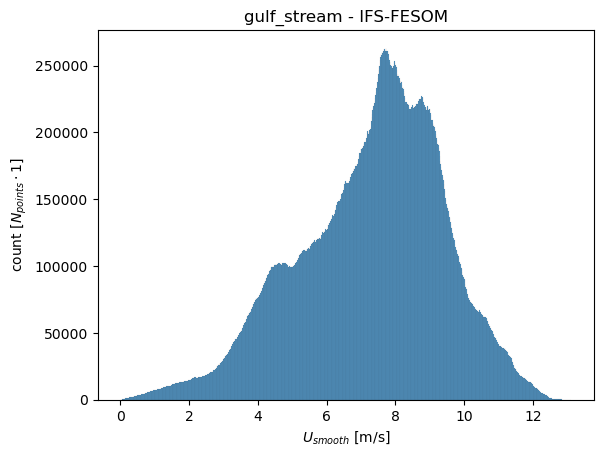

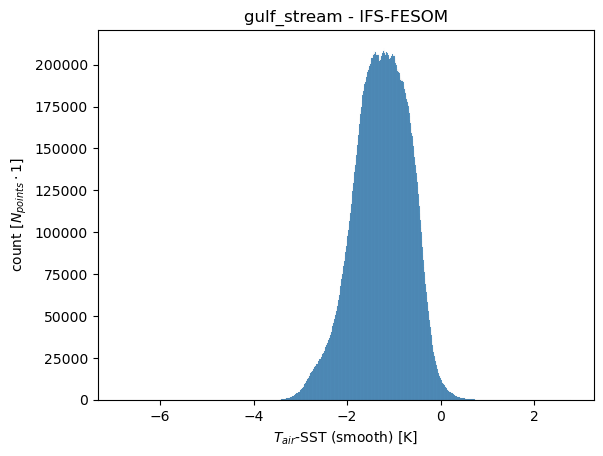

In [8]:
if True:
    #frac = 0.00001
    frac = 1
    for env_cond in env_conds:
        sns.histplot(
            data=df.sample(frac=frac),
            x=env_cond,
            #hue='coastal',
        )
        plt.xlabel(f'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}')
        plt.ylabel(rf'count [$N_{{points}} \cdot {frac}$]')
        plt.title(f'{area_str} - IFS-FESOM')
        plt.show()

## Compare env cond

In [9]:
if False:
    for env_cond_comparison in env_cond_comparison_ar:
        x_env_cond = env_cond_comparison[0]
        y_env_cond = env_cond_comparison[1]
        hue_env_cond = env_cond_comparison[2]
        
        # Reduce the number of points consider to speed-up the plotting
        # especially for hue plots
        frac = 0.00001

        if x_env_cond not in env_conds or y_env_cond not in env_conds or (hue_env_cond not in env_conds and hue_env_cond != None):
            print(f'Env conditions not provided: {x_env_cond}, {y_env_cond}, {hue_env_cond}')
        else:    

            if hue_env_cond == None:
                joinplot = sns.jointplot(
                    x = df[x_env_cond],
                    y = df[y_env_cond], 
                    kind='hex',
                ) 
                joinplot.set_axis_labels(
                    env_conds_plot_attrs[x_env_cond]['axis_label'] + ' ' + env_conds_plot_attrs[x_env_cond]['unit'],
                    env_conds_plot_attrs[y_env_cond]['axis_label'] + ' ' + env_conds_plot_attrs[y_env_cond]['unit'])
                #joinplot.set(title=f'Fraction of points: {frac}')
            else:
                fig, ax = plt.subplots()
                # Plotting the environmental conditions comparison
                plot = sns.scatterplot(
                    data=df.sample(frac=frac),
                    x=x_env_cond,
                    y=y_env_cond,
                    hue=hue_env_cond,
                    palette='turbo',
                    s=10,
                    ax=ax,
                )
                plot.legend_.set_title(env_conds_plot_attrs[hue_env_cond]['axis_label'] + ' ' + env_conds_plot_attrs[hue_env_cond]['unit'])
    
                ax.set_xlabel(env_conds_plot_attrs[x_env_cond]['axis_label'] + ' ' + env_conds_plot_attrs[x_env_cond]['unit'])
                ax.set_ylabel(env_conds_plot_attrs[y_env_cond]['axis_label'] + ' ' + env_conds_plot_attrs[y_env_cond]['unit'])
                ax.grid()
                ax.set_title(f'Fraction of points: {frac}')

            # Custom x-axis tick labels
            if x_env_cond == 'log_L_ML_50':
                ax.set_xticks([-2.5, -0.5])
                ax.set_xticklabels(['Marginally Unstable (' + str(-2.5) + ')', 'Unstable (' + str(-0.5) + ')'])

            if enable_save_figures:
                raise NameError('Implement')
                plt.savefig(os.path.join(
                    '/atlantic/data_lorenzo/scatterplots_env_cond',
                    f'{file2read[:-4]}_{database}_{x_env_cond}_{y_env_cond}_{hue_env_cond}.png'),
                    bbox_inches="tight",
                    dpi=200
                    )

            plt.show()


## Geographical distributions

In [10]:
if False and 'lon' in cols_to_extract and 'lat' in cols_to_extract:
    cmap = mpl.cm.get_cmap('Blues') 
    norm = mpl.colors.Normalize(vmin=0, vmax=2000)

    for env_cond in env_conds:
        if len(env_cond_class_dict[env_cond][:-1]) == 2:
            fig,axes = plt.subplots(1,2,figsize=(20,8))
        if len(env_cond_class_dict[env_cond][:-1]) == 3:
            fig,axes = plt.subplots(1,3,figsize=(28,8))
        if len(env_cond_class_dict[env_cond][:-1]) == 4:
            fig,axes = plt.subplots(2,2,figsize=(20,18))
        axes = axes.flatten()

        # Loop over the prescribed env classes
        for i,env_cond_class in enumerate(env_cond_class_dict[env_cond][:-1]):
            env_cond_class_df = df.loc[(df[env_cond] > env_cond_class[0]) & (df[env_cond] < env_cond_class[1])]
            if env_cond_class_df.empty: 
                print(f'{env_cond_class} empty')
                continue
            
            # Get the min and max values for longitude and latitude
            min_lon, max_lon = env_cond_class_df.lon.min(), env_cond_class_df.lon.max()
            min_lat, max_lat = env_cond_class_df.lat.min(), env_cond_class_df.lat.max()

            # Create a Basemap instance with dynamic boundaries
            m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[i])
            m.drawcoastlines()
            m.drawcountries()
            m.drawmapboundary()

            # Draw latitude and longitude grid lines
            m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
            m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)

            polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
            m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')

            # Convert longitude and latitude to map projection coordinates
            x, y = m(env_cond_class_df.lon.values, env_cond_class_df.lat.values)

            # Plot the hexbin plot on the map
            hb = axes[i].hexbin(x, y, gridsize=50, cmap = cmap, norm = norm, mincnt=1)

            axes[i].set_title(f"{env_cond_class[0]} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} < {env_conds_plot_attrs[env_cond]['axis_label']} < {env_cond_class[1]} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}")


        # Add a single colorbar for all subplots
        bbox = axes[0].get_position()  # Get the position of the first subplot
        bbox_last = axes[-1].get_position()  # Get the position of the last subplot
        #cbar_ax = fig.add_axes([0.92, bbox_last.y0, 0.02, bbox.y1 - bbox_last.y0])  # [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.92, 0.22, 0.02, 0.55])  # [left, bottom, width, height]
        fig.colorbar(hb, cax=cbar_ax, orientation='vertical').set_label('Counts')
        fig.subplots_adjust(hspace=-0.4, right=0.9)  # Adjust spacing and leave room for the colorbar
        
        plt.show()
            

### SST gradients

In [11]:
if False:
    fig, axes = plt.subplots(1,2,figsize=(20, 8))
    cmap = mpl.cm.get_cmap('Blues') 
    norm = mpl.colors.Normalize(vmin=0, vmax=2000)
    
    ### Negative SST gradient
    selected_df = df.loc[(df['control']<-1e-5)]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[0])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Plot the hexbin plot on the map
    hb = axes[0].hexbin(x, y, gridsize=50, cmap=cmap, norm=norm, mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[0].set_title('$d SST/d r< -10^{-5} K/m$ ')
    
    
    ### Positive SST gradient 
    selected_df = df.loc[(df['control']>1e-5)]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[1])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = axes[1].hexbin(x, y, gridsize=50, cmap=cmap, norm=norm, mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[1].set_title('$d SST/d r > 10^{-5} K/m$ ')
    
    plt.show()

In [12]:
if False:
    selected_df = df.loc[(df['control']>-1e-5) & (df['control']<1e-5)]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    norm = mpl.colors.Normalize(vmin=0, vmax=2000)
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', norm=norm, mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title('$|d SST/d r| < 10^{-5} K/m$')
    
    plt.show()

In [13]:
if False:
    selected_df = df.loc[(df['control']>-1e-5) & (df['control']<0)]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    norm = mpl.colors.Normalize(vmin=0, vmax=2000)
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', norm=norm, mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title('$ -10^{-5} < d SST/d r < 0 K/m$')
    
    plt.show()

### Cloud cover

In [14]:
if False:
    selected_df = df.loc[(df['tcc_era5'] < 0.2)]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title('$cloud cover < 0.2$')
    
    plt.show()

In [15]:
if False:
    selected_df = df.loc[(df['control']<-1e-5) & (df['tcc_era5'] < 0.2)]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title('$d SST/d r< -10^{-5} K/m$ and $cloud cover < 0.2$')
    
    plt.show()

In [16]:
if False:
    fig, axes = plt.subplots(1,2,figsize=(20, 8))
    
    
    ### From land
    selected_df = df.loc[(df['control']<-1e-5) & (df['tcc_era5'] < 0.2) & ((225 < df['wdir_era5']) | (df['wdir_era5'] < 45))]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[0])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = axes[0].hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[0].set_title('$d SST/d r< -10^{-5} K/m$ and $cloud cover < 0.2$, wind from land')
    
    
    ### From ocean 
    selected_df = df.loc[(df['control']<-1e-5) & (df['tcc_era5'] < 0.2) & (45 < df['wdir_era5']) & (df['wdir_era5'] < 225) ]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[1])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = axes[1].hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[1].set_title('$d SST/d r< -10^{-5} K/m$ and $cloud cover < 0.2$, wind from ocean')
    
    plt.show()

### Air-sea potential temp diff

In [17]:
if False:
    fig, axes = plt.subplots(1,2,figsize=(20, 8))
    
    
    ### From land
    selected_df = df.loc[(df['air_sea_theta_diff_era5'] < -4) & ((225 < df['wdir_era5']) | (df['wdir_era5'] < 45))]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[0])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = axes[0].hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[0].set_title(f'{env_conds_plot_attrs['air_sea_theta_diff_era5']['axis_label']} < -4 K, wind from land')
    
    
    ### From ocean
    selected_df = df.loc[(df['air_sea_theta_diff_era5'] < -4) & (45 < df['wdir_era5']) & (df['wdir_era5'] < 225)]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[1])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = axes[1].hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[1].set_title(f'{env_conds_plot_attrs['air_sea_theta_diff_era5']['axis_label']} < -4 K, wind from ocean')
    
    plt.show()

In [18]:
if False:
    fig, axes = plt.subplots(1,2,figsize=(20, 8))
    
    
    ### From land
    selected_df = df.loc[(df['control']<-1e-5) & (df['air_sea_theta_diff_era5'] < -4) & ((225 < df['wdir_era5']) | (df['wdir_era5'] < 45))]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[0])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = axes[0].hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[0].set_title(f'$d SST/d r< -10^{-5} K/m$ and {env_conds_plot_attrs['air_sea_theta_diff_era5']['axis_label']} < -4 K, wind from land')
    
    
    ### From ocean 
    selected_df = df.loc[(df['control']<-1e-5) & (df['air_sea_theta_diff_era5'] < -4) & (45 < df['wdir_era5']) & (df['wdir_era5'] < 225) ]
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=axes[1])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = axes[1].hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    axes[1].set_title(f'$d SST/d r< -10^{-5} K/m$ and {env_conds_plot_attrs['air_sea_theta_diff_era5']['axis_label']} < -4 K, wind from ocean')
    
    plt.show()

### Relative humidity

In [19]:
if False:
    selected_df = df.loc[(df['RH_era5'] < 60) ]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title(r'$RH < 60\%$')
    
    plt.show()

In [20]:
if False:
    selected_df = df.loc[(df['RH_era5'] < 60) & (df['air_sea_theta_diff_era5'] < -4)]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title(rf'$RH < 60\%$ and {env_conds_plot_attrs['air_sea_theta_diff_era5']['axis_label']} < -4K')
    
    plt.show()

In [21]:
if False:
    selected_df = df.loc[(df['control']<-1e-5) & (df['RH_era5'] < 60) ]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title(r'$d SST/d r < -10^{-5} K/m$, $RH < 60\%$')
    
    plt.show()

In [22]:
if False:
    selected_df = df.loc[(df['control']>-1e-5) & (df['control']<1e-5) & (df['RH_era5'] < 60) ]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the min and max values for longitude and latitude
    min_lon, max_lon = selected_df.lon.min(), selected_df.lon.max()
    min_lat, max_lat = selected_df.lat.min(), selected_df.lat.max()
    
    # Create a Basemap instance with dynamic boundaries
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    
    # Draw latitude and longitude grid lines
    m.drawparallels(range(int(min_lat), int(max_lat)+1, 5), labels=[1,0,0,0], linewidth=0.5)
    m.drawmeridians(range(int(min_lon), int(max_lon)+1, 5), labels=[0,0,0,1], linewidth=0.5)
    
    # Plot the polygon on the first subplot
    polygon_x, polygon_y = m(*zip(*coastal_sector_coords))
    m.plot(polygon_x, polygon_y, marker=None, color='r', label='Coastal Sector')
    
    # Convert longitude and latitude to map projection coordinates
    x, y = m(selected_df.lon.values, selected_df.lat.values)
    
    # Plot the hexbin plot on the map
    hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1)
    
    # Create an axis for the color bar that matches the height of the main plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Add a color bar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label('Counts')
    
    ax.set_title(r'$|d SST/d r| < 10^{-5} K/m$, $RH < 60\%$')
    
    plt.show()

# Coupling trends as a function of environmental conditions

## Varying one environmental class at the time - Wind response




 ################################################################################################ 
                    smooth_ws 
 ################################################################################################ 
	 env cond class : [0, 5]
	Not enough points in control bin (-0.000129, -0.000118] : 3
	Not enough points in control bin (-0.000118, -0.000107] : 1
	Not enough points in control bin (-0.000107, -9.67e-05] : 0
	Not enough points in control bin (-9.67e-05, -8.59e-05] : 1
	Not enough points in control bin (-8.59e-05, -7.52e-05] : 4
	Not enough points in control bin (-7.52e-05, -6.44e-05] : 38
	Not enough points in control bin (-6.44e-05, -5.36e-05] : 33
	(-5.36e-05, -4.28e-05] : 79
	(-4.28e-05, -3.2e-05] : 135
	(-3.2e-05, -2.13e-05] : 370
	(-2.13e-05, -1.05e-05] : 4010
	(-1.05e-05, 2.78e-07] : 9065856
	(2.78e-07, 1.11e-05] : 5273682
	(1.11e-05, 2.18e-05] : 6654
	(2.18e-05, 3.26e-05] : 1525
	(3.26e-05, 4.34e-05] : 574
	(4.34e-05, 5.42e-05] : 121
	Not enough poin

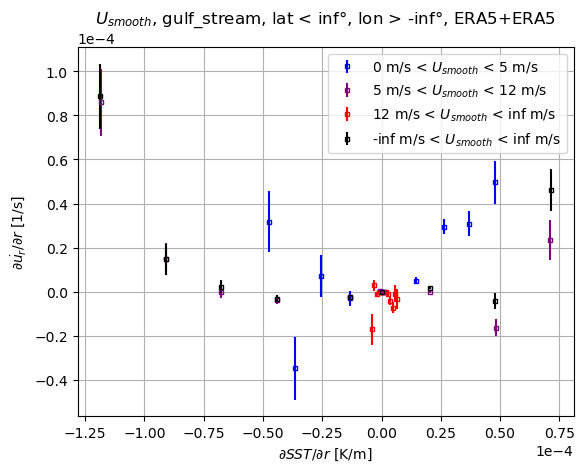

### Results ###


,smooth_ws_class,n_points_bin,coeff,coeff_err,naive_coeff,intercept,intercept_err
0,"[0, 5]",14353145,-0.153421,0.020195,0.438650,-6.460293e-08,1.871675e-08
1,"[5, 12]",75773918,0.035843,0.014601,-0.253620,-1.262680e-07,5.740225e-09
2,"[12, inf]",251535,-0.058105,0.123315,0.189805,-7.536824e-08,8.127855e-08
3,"[-inf, inf]",90378600,0.071186,0.014531,-0.172205,-1.169564e-07,5.662242e-09





 ################################################################################################ 
                    smooth_air_sea_temp_diff 
 ################################################################################################ 
[-inf, -8] empty
	 env cond class : [-8, -4]
	Not enough points in control bin (-2.73e-05, -2.49e-05] : 9
	Not enough points in control bin (-2.49e-05, -2.25e-05] : 2
	Not enough points in control bin (-2.25e-05, -2.01e-05] : 10
	Not enough points in control bin (-2.01e-05, -1.78e-05] : 14
	Not enough points in control bin (-1.78e-05, -1.54e-05] : 35
	Not enough points in control bin (-1.54e-05, -1.3e-05] : 46
	(-1.3e-05, -1.07e-05] : 66
	(-1.07e-05, -8.31e-06] : 127
	(-8.31e-06, -5.95e-06] : 332
	(-5.95e-06, -3.58e-06] : 646
	(-3.58e-06, -1.22e-06] : 983
	(-1.22e-06, 1.15e-06] : 1750
	(1.15e-06, 3.51e-06] : 480
	(3.51e-06, 5.88e-06] : 99
	Not enough points in control bin (5.88e-06, 8.24e-06] : 47
	Not enough points in control bin (8.24e-06, 1

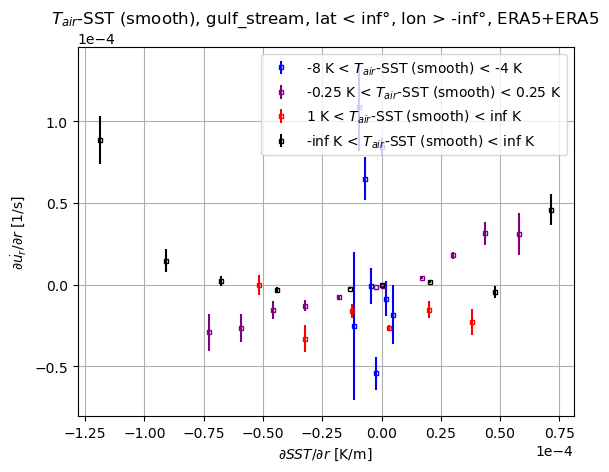

### Results ###


,smooth_air_sea_temp_diff_class,n_points_bin,coeff,coeff_err,naive_coeff,intercept,intercept_err
0,"[-8, -4]",4713,1.068978,1.195868,-2.643709,4.113846e-05,3.949585e-06
1,"[-0.25, 0.25]",2331535,0.199143,0.019255,0.477380,-1.116275e-06,3.289990e-08
2,"[1, inf]",4793,-0.217275,0.085865,-0.118125,-2.332779e-05,1.391631e-06
3,"[-inf, inf]",90378600,0.071186,0.014531,-0.172205,-1.169564e-07,5.662242e-09


In [23]:
for env_cond in env_conds:
    print(f'\n\n\n ################################################################################################ \n                    {env_cond} \n ################################################################################################ ')

    coeff_ar = []
    coeff_err_ar = []
    naive_coeff_ar = []
    intercept_ar = []
    intercept_err_ar = []
    env_cond_class_ar = []
    n_points_ar = []
    fig,ax = plt.subplots()

    # Loop over the prescribed env classes
    for i,env_cond_class in enumerate(env_cond_class_dict[env_cond]):
        env_cond_class_df = df.loc[(df[env_cond] > env_cond_class[0]) & (df[env_cond] < env_cond_class[1])]
        
        # Temporary lat-lon filter
        if 'lon' in cols_to_extract and 'lat' in cols_to_extract:
            env_cond_class_df = env_cond_class_df.loc[(env_cond_class_df.lat<lat_north_threshold) & (env_cond_class_df.lon>lon_west_threshold)]
            #env_cond_class_df = env_cond_class_df.loc[(env_cond_class_df.lat>40)]
        

        if env_cond_class_df.empty: 
            print(f'{env_cond_class} empty')
            continue
        
        print(f'\t env cond class : {env_cond_class}')

        # Container for binned data
        control_bin_ar = []
        mean_response_ar = []
        err_response_ar = [] # standard error == st_dev / sqrt(N)
        mean_control_ar = []
        # Track the number of points which contributed to that control bin
        n_points_bin_ar = []


        # Compute control bins
        control_bin_ds = pd.cut(
                env_cond_class_df[sst_deriv],
                control_bins,
        )

        env_cond_class_df['control_bin'] = control_bin_ds

        # Compute avg control and response variable and corresponding uncertainties
        # from the bins defined on the basis of the control variable.  
        for control_bin,group_by_control_bin in env_cond_class_df.groupby(by="control_bin"):
            # Set a minimum number of point for each control bin to be accepted
            if len(group_by_control_bin) < control_bin_n_points_threshold: 
                print('\tNot enough points in control bin '+str(control_bin)+' : '+str(len(group_by_control_bin)))
                continue
            elif not control_bin.left < group_by_control_bin[sst_deriv].mean() < control_bin.right:
                raise NameError('Something is off with the control bins')
            n_points_bin_ar.append(len(group_by_control_bin))
            control_bin_ar.append(control_bin)
            mean_response_ar.append(group_by_control_bin[wind_deriv].mean())
            if control_bin_error == 'sem':
                err_response_ar.append(group_by_control_bin[wind_deriv].sem())
            elif control_bin_error == 'std':
                err_response_ar.append(group_by_control_bin[wind_deriv].std())
            else:
                raise NameError('Control bin error unknown')
            mean_control_ar.append(group_by_control_bin[sst_deriv].mean())
            
            #perform Shapiro-Wilk test for normality
            print('\t'+str(control_bin)+' : '+str(len(group_by_control_bin)))
            # Test normality within control bins
            if False:
                print(stats.shapiro(group_by_control_bin[wind_deriv]))




        # We check if the number of points associated to control bins is enough 
        # for the lin regress to be reliable 
        if len(control_bin_ar) < n_control_bins_threshold:
            print('Not enough valid control bins')
            continue
        

        # Compute coeff with a simple linear fit
        naive_linreg_result = stats.linregress(
            mean_control_ar,               
            mean_response_ar
            )
        naive_coeff = naive_linreg_result.slope
        naive_intercept = naive_linreg_result.intercept
        # coeff_p_value = linreg_result.pvalue
        # coeff_err = linreg_result.stderr
        # r_value = linreg_result.rvalue
        # n_points = len(group_by_env_cond_bin)
        
        # Take into account uncertainties in lin regr
        linreg_result = weighted_linear_regression_with_pvalues(
            mean_control_ar,
            mean_response_ar,
            err_response_ar
        )
        coeff = linreg_result['slope'][0]
        coeff_err = linreg_result['slope'][1]
        #coeff_p_value = linreg_result['slope'][2]
        # Temporarily taking p_value and r_value from an other method
        # coeff_p_value = stats.linregress(
        #     mean_control_ar,               
        #     mean_response_ar
        #     ).pvalue
        # r_value = stats.linregress(
        #     mean_control_ar,               
        #     mean_response_ar
        #     ).rvalue
        intercept = linreg_result['intercept'][0]
        intercept_err = linreg_result['intercept'][1]
        q = linreg_result['q']
        n_points = len(env_cond_class_df)
        

        if True:    
            ax.errorbar(
                mean_control_ar,
                mean_response_ar, 
                yerr=err_response_ar, 
                linestyle='',
                markerfacecolor='None',
                marker='s',
                markersize=3,
                markeredgecolor=env_cond_class_color_dict[env_cond][i],
                ecolor=env_cond_class_color_dict[env_cond][i],
                label=f"{env_cond_class[0]} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} < {env_conds_plot_attrs[env_cond]['axis_label']} < {env_cond_class[1]} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}"
                )

        # Save infor on current env cond
        coeff_ar.append(coeff)
        naive_coeff_ar.append(naive_coeff)
        coeff_err_ar.append(coeff_err)
        intercept_ar.append(intercept)
        intercept_err_ar.append(intercept_err)
        env_cond_class_ar.append(env_cond_class)
        n_points_ar.append(n_points)

    ax.set_xlabel(sst_deriv_label)
    ax.set_ylabel(wind_deriv_label)
    ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']}, {area_str}, lat < {lat_north_threshold}°, lon > {lon_west_threshold}°, ERA5+ERA5')
    #ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']}, {area_str}, lat > 40°, lon > {lon_west_threshold}°, ERA5+ERA5')
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.legend()
    ax.grid()
    plt.show()
    #fig.show()

    coupling_coeff_env_cond_distr_df = pd.DataFrame.from_dict(
        {
            env_cond+'_class' : env_cond_class_ar,
            'n_points_bin' : n_points_ar,
            'coeff' : coeff_ar,
            'coeff_err' : coeff_err_ar,
            'naive_coeff' : naive_coeff_ar,
            'intercept' : intercept_ar,
            'intercept_err' : intercept_err_ar,
        }
    )

    print('### Results ###')
    display(coupling_coeff_env_cond_distr_df)

    del ax,fig,coeff_ar,coeff_err_ar,naive_coeff_ar,intercept_ar,intercept_err_ar,env_cond_class_ar,n_points_ar,mean_control_ar,mean_response_ar,n_points_bin_ar

## Varying one environmental class at the time - BLH response




 ################################################################################################ 
                    smooth_ws 
 ################################################################################################ 
	 env cond class : [0, 5]
	Not enough points in control bin (-0.000129, -0.000118] : 3
	Not enough points in control bin (-0.000118, -0.000107] : 1
	Not enough points in control bin (-0.000107, -9.67e-05] : 0
	Not enough points in control bin (-9.67e-05, -8.59e-05] : 1
	Not enough points in control bin (-8.59e-05, -7.52e-05] : 4
	Not enough points in control bin (-7.52e-05, -6.44e-05] : 38
	Not enough points in control bin (-6.44e-05, -5.36e-05] : 33
	(-5.36e-05, -4.28e-05] : 79
	(-4.28e-05, -3.2e-05] : 135
	(-3.2e-05, -2.13e-05] : 370
	(-2.13e-05, -1.05e-05] : 4010
	(-1.05e-05, 2.78e-07] : 9065856
	(2.78e-07, 1.11e-05] : 5273682
	(1.11e-05, 2.18e-05] : 6654
	(2.18e-05, 3.26e-05] : 1525
	(3.26e-05, 4.34e-05] : 574
	(4.34e-05, 5.42e-05] : 121
	Not enough poin

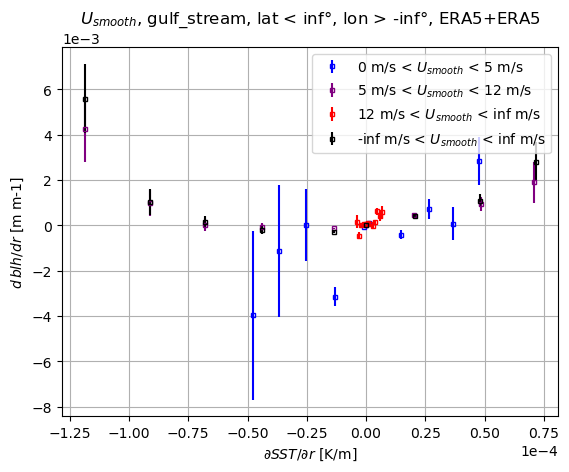

### Results ###


,smooth_ws_class,n_points_bin,coeff,coeff_err,naive_coeff,intercept,intercept_err
0,"[0, 5]",14353145,100.370058,2.829892,47.208656,-0.000007,2.660834e-06
1,"[5, 12]",75773918,12.163129,1.287147,-6.643380,0.000023,6.607798e-07
2,"[12, inf]",251535,24.559705,8.673715,61.133744,0.000073,6.353649e-06
3,"[-inf, inf]",90378600,14.731532,1.384305,-8.100157,0.000018,6.971668e-07





 ################################################################################################ 
                    smooth_air_sea_temp_diff 
 ################################################################################################ 
[-inf, -8] empty
	 env cond class : [-8, -4]
	Not enough points in control bin (-2.73e-05, -2.49e-05] : 9
	Not enough points in control bin (-2.49e-05, -2.25e-05] : 2
	Not enough points in control bin (-2.25e-05, -2.01e-05] : 10
	Not enough points in control bin (-2.01e-05, -1.78e-05] : 14
	Not enough points in control bin (-1.78e-05, -1.54e-05] : 35
	Not enough points in control bin (-1.54e-05, -1.3e-05] : 46
	(-1.3e-05, -1.07e-05] : 66
	(-1.07e-05, -8.31e-06] : 127
	(-8.31e-06, -5.95e-06] : 332
	(-5.95e-06, -3.58e-06] : 646
	(-3.58e-06, -1.22e-06] : 983
	(-1.22e-06, 1.15e-06] : 1750
	(1.15e-06, 3.51e-06] : 480
	(3.51e-06, 5.88e-06] : 99
	Not enough points in control bin (5.88e-06, 8.24e-06] : 47
	Not enough points in control bin (8.24e-06, 1

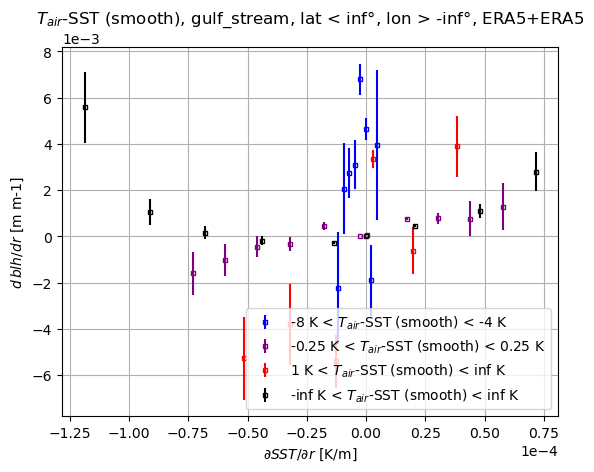

### Results ###


,smooth_air_sea_temp_diff_class,n_points_bin,coeff,coeff_err,naive_coeff,intercept,intercept_err
0,"[-8, -4]",4713,168.950881,106.150221,178.458771,0.004650,3.836038e-04
1,"[-0.25, 0.25]",2331535,21.014644,2.148956,19.257026,0.000045,4.106598e-06
2,"[1, inf]",4793,108.432031,19.959628,102.153652,0.001561,3.180799e-04
3,"[-inf, inf]",90378600,14.731532,1.384305,-8.100157,0.000018,6.971668e-07


In [24]:
for env_cond in env_conds:
    print(f'\n\n\n ################################################################################################ \n                    {env_cond} \n ################################################################################################ ')

    coeff_ar = []
    coeff_err_ar = []
    naive_coeff_ar = []
    intercept_ar = []
    intercept_err_ar = []
    env_cond_class_ar = []
    n_points_ar = []
    fig,ax = plt.subplots()

    # Loop over the prescribed env classes
    for i,env_cond_class in enumerate(env_cond_class_dict[env_cond]):
        env_cond_class_df = df.loc[(df[env_cond] > env_cond_class[0]) & (df[env_cond] < env_cond_class[1])]
        
        # Temporary lat-lon filter
        if 'lon' in cols_to_extract and 'lat' in cols_to_extract:
            env_cond_class_df = env_cond_class_df.loc[(env_cond_class_df.lat<lat_north_threshold) & (env_cond_class_df.lon>lon_west_threshold)]
            #env_cond_class_df = env_cond_class_df.loc[(env_cond_class_df.lat>40)]
        

        if env_cond_class_df.empty: 
            print(f'{env_cond_class} empty')
            continue
        
        print(f'\t env cond class : {env_cond_class}')

        # Container for binned data
        control_bin_ar = []
        mean_response_ar = []
        err_response_ar = [] # standard error == st_dev / sqrt(N)
        mean_control_ar = []
        # Track the number of points which contributed to that control bin
        n_points_bin_ar = []


        # Compute control bins
        control_bin_ds = pd.cut(
                env_cond_class_df[sst_deriv],
                control_bins,
        )

        env_cond_class_df['control_bin'] = control_bin_ds

        # Compute avg control and response variable and corresponding uncertainties
        # from the bins defined on the basis of the control variable.  
        for control_bin,group_by_control_bin in env_cond_class_df.groupby(by="control_bin"):
            # Set a minimum number of point for each control bin to be accepted
            if len(group_by_control_bin) < control_bin_n_points_threshold: 
                print('\tNot enough points in control bin '+str(control_bin)+' : '+str(len(group_by_control_bin)))
                continue
            elif not control_bin.left < group_by_control_bin[sst_deriv].mean() < control_bin.right:
                raise NameError('Something is off with the control bins')
            n_points_bin_ar.append(len(group_by_control_bin))
            control_bin_ar.append(control_bin)
            mean_response_ar.append(group_by_control_bin[blh_deriv].mean())
            if control_bin_error == 'sem':
                err_response_ar.append(group_by_control_bin[blh_deriv].sem())
            elif control_bin_error == 'std':
                err_response_ar.append(group_by_control_bin[blh_deriv].std())
            else:
                raise NameError('Control bin error unknown')
            mean_control_ar.append(group_by_control_bin[sst_deriv].mean())
            
            #perform Shapiro-Wilk test for normality
            print('\t'+str(control_bin)+' : '+str(len(group_by_control_bin)))
            # Test normality within control bins
            if False:
                print(stats.shapiro(group_by_control_bin[blh_deriv]))




        # We check if the number of points associated to control bins is enough 
        # for the lin regress to be reliable 
        if len(control_bin_ar) < n_control_bins_threshold:
            print('Not enough valid control bins')
            continue
        

        # Compute coeff with a simple linear fit
        naive_linreg_result = stats.linregress(
            mean_control_ar,               
            mean_response_ar
            )
        naive_coeff = naive_linreg_result.slope
        naive_intercept = naive_linreg_result.intercept
        # coeff_p_value = linreg_result.pvalue
        # coeff_err = linreg_result.stderr
        # r_value = linreg_result.rvalue
        # n_points = len(group_by_env_cond_bin)
        
        # Take into account uncertainties in lin regr
        linreg_result = weighted_linear_regression_with_pvalues(
            mean_control_ar,
            mean_response_ar,
            err_response_ar
        )
        coeff = linreg_result['slope'][0]
        coeff_err = linreg_result['slope'][1]
        #coeff_p_value = linreg_result['slope'][2]
        # Temporarily taking p_value and r_value from an other method
        # coeff_p_value = stats.linregress(
        #     mean_control_ar,               
        #     mean_response_ar
        #     ).pvalue
        # r_value = stats.linregress(
        #     mean_control_ar,               
        #     mean_response_ar
        #     ).rvalue
        intercept = linreg_result['intercept'][0]
        intercept_err = linreg_result['intercept'][1]
        q = linreg_result['q']
        n_points = len(env_cond_class_df)
        

        if True:    
            ax.errorbar(
                mean_control_ar,
                mean_response_ar, 
                yerr=err_response_ar, 
                linestyle='',
                markerfacecolor='None',
                marker='s',
                markersize=3,
                markeredgecolor=env_cond_class_color_dict[env_cond][i],
                ecolor=env_cond_class_color_dict[env_cond][i],
                label=f"{env_cond_class[0]} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} < {env_conds_plot_attrs[env_cond]['axis_label']} < {env_cond_class[1]} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}"
                )

        # Save infor on current env cond
        coeff_ar.append(coeff)
        naive_coeff_ar.append(naive_coeff)
        coeff_err_ar.append(coeff_err)
        intercept_ar.append(intercept)
        intercept_err_ar.append(intercept_err)
        env_cond_class_ar.append(env_cond_class)
        n_points_ar.append(n_points)

    ax.set_xlabel(sst_deriv_label)
    ax.set_ylabel(blh_deriv_label)
    ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']}, {area_str}, lat < {lat_north_threshold}°, lon > {lon_west_threshold}°, ERA5+ERA5')
    #ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']}, {area_str}, lat > 40°, lon > {lon_west_threshold}°, ERA5+ERA5')
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.legend()
    ax.grid()
    plt.show()
    #fig.show()

    coupling_coeff_env_cond_distr_df = pd.DataFrame.from_dict(
        {
            env_cond+'_class' : env_cond_class_ar,
            'n_points_bin' : n_points_ar,
            'coeff' : coeff_ar,
            'coeff_err' : coeff_err_ar,
            'naive_coeff' : naive_coeff_ar,
            'intercept' : intercept_ar,
            'intercept_err' : intercept_err_ar,
        }
    )

    print('### Results ###')
    display(coupling_coeff_env_cond_distr_df)

    del ax,fig,coeff_ar,coeff_err_ar,naive_coeff_ar,intercept_ar,intercept_err_ar,env_cond_class_ar,n_points_ar,mean_control_ar,mean_response_ar,n_points_bin_ar